In [1]:
# !pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
# !pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
# !pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
# !pip install git+https://github.com/pyg-team/pytorch_geometric.git

# Imports

In [203]:
import os
import scipy
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import io
from typing import Union, Any, Optional, List, Dict, Tuple
from tqdm import tqdm

from dataclasses import dataclass, field
from pathlib import Path

import torch
from torch import nn
from torch.nn import functional as F
from torch import Tensor
from torch.nn import Parameter, Linear

from sklearn.metrics import f1_score, accuracy_score, roc_auc_score

import torch_geometric
import torch_geometric as pyg
from torch_geometric.typing import Size, OptTensor
from torch_geometric.nn import global_add_pool, global_mean_pool, MessagePassing, GATConv, GCNConv, PNAConv
from torch_sparse import SparseTensor, matmul, fill_diag, sum as sparsesum, mul
from torch_geometric.nn.inits import glorot, zeros
from torch_geometric.utils import softmax
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.loader import DataLoader

In [3]:
print('torch', torch.__version__)
print('torch_geometric', torch_geometric.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

torch 2.0.0+cu118
torch_geometric 2.3.0
cuda


In [4]:
abide_txt_path = 'DATA/abide/subject_ID.txt'
abide_desc_path = 'DATA/abide/ABIDE_pcp/Phenotypic_V1_0b_preprocessed1.csv'
abide_folders = 'DATA/abide/ABIDE_pcp/cpac/filt_noglobal/'

cobre_csvs_path =  'DATA/cobre/aal/'

# Our data example

In [5]:
mat = io.loadmat(abide_folders+'51355/51355_cc200_correlation.mat')['connectivity']
mat.shape, mat.dtype

((200, 200), dtype('<f8'))

In [6]:
mat # we have 200x200 connectivity matrix with ones on the diagonal

array([[1.        , 0.27721658, 0.44255188, ..., 0.05532044, 0.30002629,
        0.49002441],
       [0.27721658, 1.        , 0.71593713, ..., 0.19948448, 0.2464389 ,
        0.52754512],
       [0.44255188, 0.71593713, 1.        , ..., 0.10978258, 0.25019925,
        0.50727236],
       ...,
       [0.05532044, 0.19948448, 0.10978258, ..., 1.        , 0.36693132,
        0.14509277],
       [0.30002629, 0.2464389 , 0.25019925, ..., 0.36693132, 1.        ,
        0.26102196],
       [0.49002441, 0.52754512, 0.50727236, ..., 0.14509277, 0.26102196,
        1.        ]])

# Fom connectivity matrices to pytorch geometric (PyG) data

In [7]:
def cm_to_edges(cm: np.ndarray):
    """
    Convert CM to (edge_index, edge_weights) of a fully connected weighted graph
    (including self-loops with zero weights)
    return: (edge_index, edge_weights)
    """
    cm = torch.FloatTensor(cm)
    index = (torch.isnan(cm) == 0).nonzero(as_tuple=True)
    edge_attr = torch.abs(cm[index])
    
    return torch.stack(index, dim=0), edge_attr

def prepare_pyg_data(
    cm: np.ndarray,
    subj_id: str,
    targets: int,
) -> Data:
    
    # fully connected graph
    n = cm.shape[0]
    edge_index, edge_attr = cm_to_edges(cm)
    
    # compute initial node embeddings -> just original weights
    x = torch.from_numpy(cm).to(device)

    # get encoded labels
    y = F.one_hot(torch.tensor([targets-1]), num_classes=2).to(device) # we took targets-1 because targets in abide are 1 and 2
    
    data = Data(
        edge_index=edge_index,
        edge_attr=edge_attr,
        x=x,
        num_nodes=n,
        y=y,
        subj_id=subj_id,
    ) 
    
    return data

# ABIDE

Description of columns in Phenotypic_V1_0b_preprocessed1.csv: http://fcon_1000.projects.nitrc.org/indi/abide/ABIDEII_Data_Legend.pdf

In [8]:
abide_desc = pd.read_csv(abide_desc_path)
abide_desc.head()

# DX_GROUP. Diagnostic Group. Numeric. 1 = Autism; 2 = Control.
# PDD_DSM_IV_TR DSM-IV-TR PDD Category Numeric 0=none; 1=Autism; 2=Aspergers; 3=PDD-NOS

,Unnamed: 0,Unnamed: 0.1,SUB_ID,X,subject,SITE_ID,FILE_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,...,qc_notes_rater_1,qc_anat_rater_2,qc_anat_notes_rater_2,qc_func_rater_2,qc_func_notes_rater_2,qc_anat_rater_3,qc_anat_notes_rater_3,qc_func_rater_3,qc_func_notes_rater_3,SUB_IN_SMP
0,0,1,50002,1,50002,PITT,no_filename,1,1,16.77,...,NaN,OK,NaN,fail,ic-parietal-cerebellum,OK,NaN,fail,ERROR #24,1
1,1,2,50003,2,50003,PITT,Pitt_0050003,1,1,24.45,...,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN,1
2,2,3,50004,3,50004,PITT,Pitt_0050004,1,1,19.09,...,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN,1
3,3,4,50005,4,50005,PITT,Pitt_0050005,1,1,13.73,...,NaN,OK,NaN,maybe,ic-parietal-cerebellum,OK,NaN,OK,NaN,0
4,4,5,50006,5,50006,PITT,Pitt_0050006,1,1,13.37,...,NaN,OK,NaN,maybe,ic-parietal slight,OK,NaN,OK,NaN,1


In [9]:
np.unique(abide_desc.DX_GROUP, return_counts=True)

(array([1, 2], dtype=int64), array([539, 573], dtype=int64))

In [10]:
np.unique(abide_desc.DSM_IV_TR, return_counts=True)

(array([-9999,     0,     1,     2,     3,     4], dtype=int64),
 array([ 72, 558, 347,  93,  36,   6], dtype=int64))

In [11]:
abide_subj = list(abide_desc.subject)
group = np.array(abide_desc.DX_GROUP)
abide_subj[:10], group[:10]

([50002, 50003, 50004, 50005, 50006, 50007, 50008, 50009, 50010, 50011],
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64))

In [12]:
X = []
Y = []
subj_ids = []
missed_ids = []
for subj, y in zip(abide_subj, group):
    try:
        X.append(scipy.io.loadmat(abide_folders+str(subj)+'/'+str(subj)+'_cc200_correlation.mat')['connectivity'])
        Y.append(y)
        subj_ids.append(str(subj))
    except:
        missed_ids.append(str(subj))
    
X = np.array(X)
Y = np.array(Y)

subj_ids = np.array(subj_ids)

In [13]:
dict_X = dict(zip(subj_ids, X))
dict_Y =  dict(zip(subj_ids, Y))

In [14]:
abide_splits = json.load(open('DATA/abide/abide_splits.json')) # we use same train-test split for classic ML and deep NL models 
train_ids = abide_splits['0']['train']+abide_splits['0']['valid']
test_ids = abide_splits['test']

In [15]:
len(train_ids), len(test_ids) # the dataset is pretty small, we need to be sure not to overfit

(828, 207)

Graph NN has specific batching - Graph layers can serve only one matrix as input (only $2D$ input) so for batch several matrices $A_i$ are stacked in one big matrix $A$. Because of that we create two dataloaders - common one from torch and specific from torch_geometric.

for reference: https://pytorch-geometric.readthedocs.io/en/latest/advanced/batching.html

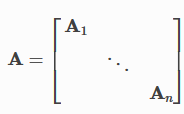

In [16]:
# creation of PyG dataloaders and common dataloaders
# PyG data has specific batching

train_inps, train_tgts = [], []
train_loader_pyg = []
for x, subj_id, y in zip(X, train_ids, Y):
    train_loader_pyg.append(prepare_pyg_data(dict_X[subj_id], subj_id, dict_Y[subj_id]))
    train_inps.append(dict_X[subj_id])
    train_tgts.append(F.one_hot(torch.tensor([dict_Y[subj_id]-1]), num_classes=2).to(device))

test_inps, test_tgts = [], []
test_loader_pyg = []
for x, subj_id, y in zip(X, test_ids, Y):
    test_loader_pyg.append(prepare_pyg_data(dict_X[subj_id], subj_id, dict_Y[subj_id]))
    test_inps.append(dict_X[subj_id])
    test_tgts.append(F.one_hot(torch.tensor([dict_Y[subj_id]-1]), num_classes=2).to(device))
    
dataset = torch.utils.data.TensorDataset(torch.Tensor(train_inps).to(device), torch.cat(train_tgts, axis=0).to(device))
train_loader_abide = torch.utils.data.DataLoader(dataset, batch_size=16)
dataset = torch.utils.data.TensorDataset(torch.Tensor(test_inps).to(device), torch.cat(test_tgts, axis=0).to(device))
test_loader_abide = torch.utils.data.DataLoader(dataset, batch_size=16)
    
train_loader_abide_pyg = DataLoader(train_loader_pyg, batch_size=8)
test_loader_abide_pyg = DataLoader(test_loader_pyg, batch_size=8)

C:\Users\med20\AppData\Local\Temp/ipykernel_11548/3330422635.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:248.)
  dataset = torch.utils.data.TensorDataset(torch.Tensor(train_inps).to(device), torch.cat(train_tgts, axis=0).to(device))


In [17]:
next(iter(train_loader_abide))[0].shape, next(iter(train_loader_abide))[1].shape

(torch.Size([16, 200, 200]), torch.Size([16, 2]))

In [22]:
next(iter(train_loader_abide_pyg)) # x

DataBatch(x=[1600, 200], edge_index=[2, 320000], edge_attr=[320000], y=[8, 2], num_nodes=1600, subj_id=[8], batch=[1600], ptr=[9])

## COBRE

COBRE dataset is pretty small so the deep ML models overfit too easily 

In [26]:
cobre_y = pd.read_csv('DATA/cobre/meta_data.tsv', delimiter='\t')
cobre_y.head()

,Study,Projectid,Description,Subjectid,Age,Sex,Dx,Field_strength,Img_date,Datauri,Maker,Model,Szc_protocol_hier,Notes,Imaging_protocol_site,Visit
0,COBRE,1139,The Center for Biomedical Research Excellence ...,A00000300,36,male,No_Known_Disorder,3,2011-01-01 00:00:00.0,970414,Siemens,MIND TRIO 3.0T,Resting_State,NaN,MRN,NaN
1,COBRE,1139,The Center for Biomedical Research Excellence ...,A00000300,36,male,No_Known_Disorder,3,2011-01-01 00:00:00.0,980034,Siemens,MIND TRIO 3.0T,MPRAGE,NaN,MRN,NaN
2,COBRE,1139,The Center for Biomedical Research Excellence ...,A00000300,36,male,No_Known_Disorder,3,2011-01-01 00:00:00.0,980054,Siemens,MIND TRIO 3.0T,MPRAGE,NaN,MRN,NaN
3,COBRE,1139,The Center for Biomedical Research Excellence ...,A00000300,36,male,No_Known_Disorder,3,2011-01-01 00:00:00.0,980134,Siemens,MIND TRIO 3.0T,Diffusion,NaN,MRN,NaN
4,COBRE,1139,The Center for Biomedical Research Excellence ...,A00000300,36,male,No_Known_Disorder,3,2011-01-01 00:00:00.0,980154,Siemens,MIND TRIO 3.0T,Diffusion,NaN,MRN,NaN


In [27]:
cobre_splits = json.load(open('DATA/cobre/cobre_splits_new.json')) # here we also use the same train test splits as for classic ML
train_ids = [i['train']+i['valid'] for i in cobre_splits['train']]
train_ids = train_ids[0]+train_ids[1]+train_ids[2]+train_ids[3]+train_ids[4]
train_ids = list(set(train_ids))
test_ids = cobre_splits['test']

In [28]:
X = []
Y = []
subj_ids = []
missed_ids = []
for subj, y in zip(train_ids+test_ids, group):
    try:
        X.append(np.array(pd.read_csv('DATA/cobre/aal/sub-'+subj+'.csv').drop('Unnamed: 0', axis=1)))
        Y.append(y)
        subj_ids.append(str(subj))
    except:
        missed_ids.append(str(subj))
    
X = np.array(X)
Y = np.array(Y)

dict_X = dict(zip(subj_ids, X))
dict_Y = dict(zip(cobre_y[cobre_y.Subjectid.isin(subj_ids)].Subjectid, cobre_y[cobre_y.Subjectid.isin(subj_ids)].Dx))
xx, yy = dict_Y.keys(), dict_Y.values()
yy = [1 if i == 'Schizophrenia_Strict' else 2 for i in yy]
dict_Y = dict(zip(xx, yy))

In [29]:
# creation of PyG dataloaders and common dataloaders
# PyG data has specific batching

train_inps, train_tgts = [], []
train_loader_pyg = []
for x, subj_id, y in zip(X, train_ids, Y):
    train_loader_pyg.append(prepare_pyg_data(dict_X[subj_id], subj_id, dict_Y[subj_id]))
    train_inps.append(dict_X[subj_id])
    train_tgts.append(F.one_hot(torch.tensor([dict_Y[subj_id]-1]), num_classes=2).to(device))

test_inps, test_tgts = [], []
test_loader_pyg = []
for x, subj_id, y in zip(X, test_ids, Y):
    test_loader_pyg.append(prepare_pyg_data(dict_X[subj_id], subj_id, dict_Y[subj_id]))
    test_inps.append(dict_X[subj_id])
    test_tgts.append(F.one_hot(torch.tensor([dict_Y[subj_id]-1]), num_classes=2).to(device))
    
dataset = torch.utils.data.TensorDataset(torch.Tensor(train_inps).to(device), torch.cat(train_tgts, axis=0).to(device))
train_loader_cobre = torch.utils.data.DataLoader(dataset, batch_size=16)
dataset = torch.utils.data.TensorDataset(torch.Tensor(test_inps).to(device), torch.cat(test_tgts, axis=0).to(device))
test_loader_cobre = torch.utils.data.DataLoader(dataset, batch_size=16)
    
train_loader_cobre_pyg = DataLoader(train_loader_pyg, batch_size=8)
test_loader_cobre_pyg = DataLoader(test_loader_pyg, batch_size=8)

In [30]:
next(iter(train_loader_cobre))[0].shape, next(iter(train_loader_cobre))[1].shape

(torch.Size([16, 116, 116]), torch.Size([16, 2]))

In [31]:
next(iter(train_loader_cobre_pyg)) # x

DataBatch(x=[928, 116], edge_index=[2, 107648], edge_attr=[107648], y=[8, 2], num_nodes=928, subj_id=[8], batch=[928], ptr=[9])

# Train and evaluate functions

In [217]:
def evaluate(model, device, loader):
    # set model to eval
    model.eval()
    
    # init list
    loss_all = 0
    y_pred = []
    y_true = []
    
    for data in loader:
        
        data = data.to(device)
        
        out = model(data)
        
        loss = F.binary_cross_entropy_with_logits(out, data.y.float())
        loss_all += loss.item()
        
        y_pred.append(out.detach().cpu().numpy())
        y_true.append(data.y.detach().cpu().numpy())
    
    y_pred = np.concatenate(y_pred, axis=0)
    y_true = np.concatenate(y_true, axis=0)
    
    f1, acc, roc_auc = f1_score(y_true.argmax(-1), y_pred.argmax(-1)), accuracy_score(y_true.argmax(-1), y_pred.argmax(-1)), roc_auc_score(y_true.argmax(-1), y_pred[:, 1])
        
    return loss_all/len(loader.dataset), f1, acc, roc_auc

In [242]:
def train_and_evaluate(model, train_loader, test_loader, optimizer, scheduler=None, device=device, n_epochs=20, verbose=True):
    # set model to train
    model.train()
    
    # init list
    f1s = []
    accs = []
    roc_aucs = []

    for i in range(n_epochs):
        loss_all = 0
        for data in train_loader:
            data = data.to(device)
            
            # zero grads
            optimizer.zero_grad()
            
            # forward
            out = model(data)
            
            loss = F.cross_entropy(out, data.y.to(device).float())

            loss.backward()
            optimizer.step()

            loss_all += loss.item()
        
        if scheduler:
            scheduler.step()
        
        epoch_loss = loss_all / len(train_loader.dataset)

        train_loss, train_f1, train_acc, train_roc_auc = evaluate(model, device, train_loader)
        if verbose:
            print(f'(Train) | Epoch={i:03d}, loss={epoch_loss:.4f}', f'train_acc={(train_acc * 100):.2f}')

        
        test_loss, test_f1, test_acc, test_roc_auc = evaluate(model, device, test_loader)
        f1s.append(test_f1)
        accs.append(test_acc)
        roc_aucs.append(test_roc_auc)

        text = f'(Train Epoch {i}), loss={test_loss:.4f}, test_acc={(test_acc * 100):.2f}'
        
        if verbose:
            print(text)
            if scheduler:
                print('lr', scheduler.get_last_lr()[0])
            print()
    
    f1s = np.array(f1s)
    accs = np.array(accs)
    roc_aucs = np.array(roc_aucs)
    
    return f1s.max(), accs.max(), roc_aucs.max()

# Neurograph 
main idea of architechture was taken from https://github.com/gennadylaptev/neurograph/tree/main/neurograph with additions

In [243]:
@dataclass
class MLPlayer:
    """ Config of one MLP layer """
    out_size: int = 10
    act_func: Optional[str] = 'ReLU'
    act_func_params: Optional[dict] = None
    dropout: Optional[float] = None

In [244]:
@dataclass
class MLPConfig:
    """ Config of MLP model """
    # layers define only hidden dimensions, so final MLP will have n+1 layer.
    # So, if you want to create a 1-layer network, just leave layers empty

    # in and out sizes are optional and usually depend on upstream model and the task
    # for now, they are ignored
    in_size: Optional[int] = None
    out_size: Optional[int] = None

    # act func for the last layer. None -> no activation function
    act_func: Optional[str] = None
    act_func_params: Optional[dict] = None
    layers: List[MLPlayer] = field(default_factory=lambda: [
        MLPlayer(
            out_size=32, dropout=0.6, act_func='LeakyReLU', act_func_params=dict(negative_slope=0.2)
        ),
        MLPlayer(
            out_size=32, dropout=0.6, act_func='LeakyReLU', act_func_params=dict(negative_slope=0.2)
        ),
    ])

In [245]:
def build_mlp_layer(in_size: int, layer: MLPlayer) -> nn.Sequential:
    """ Factory that returns nn.Sequential from input size and MLPlayer """
    act_params = layer.act_func_params if layer.act_func_params else {}

    lst: list[nn.Module] = [nn.Linear(in_size, layer.out_size)]
    #lst.append(
    if layer.act_func:
        lst.append(nn.LeakyReLU(**act_params)) # available_activations[layer.act_func](**act_params))
    if layer.dropout:
        lst.append(nn.Dropout(layer.dropout, inplace=True))
    return nn.Sequential(*lst)

In [246]:
@dataclass
class ModelConfig:
    """ Base class for model config """
    name: str  # see neurograph.models/
    n_classes: int  # must match with loss

    # required for correct init of models
    # see `train.train.init_model`

    data_type: str

In [247]:
class BasicMLP(nn.Module):
    """ Basic MLP class """
    def __init__(self, in_size: int, out_size: int, config: MLPConfig):
        super().__init__()
        self.in_size = in_size
        self.out_size = out_size

        self.net = nn.Sequential()
        curr_size = self.in_size
        for layer_conf in config.layers:
            subnet = build_mlp_layer(curr_size, layer_conf)
            self.net.append(subnet)
            curr_size = layer_conf.out_size

        # the last layer
        self.net.append(build_mlp_layer(
            curr_size,
            MLPlayer(
                out_size=self.out_size,
                act_func=config.act_func,
                act_func_params=config.act_func_params,
            ),
        ))

    def forward(self, x):
        return self.net(x)

In [248]:
def build_gat_block(
    input_dim: int,
    hidden_dim: int,
    proj_dim: Optional[int] = None,
    mp_type: str = 'edge_node_concate',
    num_heads: int = 1,
    dropout: float = 0.0,
    use_batchnorm: bool = True,
    use_abs_weight: bool = True,
):
    proj_dim = hidden_dim if proj_dim is None else proj_dim
    return pygSequential(
        'x, edge_index, edge_attr',
        [
            (
                GATConv(
                    input_dim,
                    hidden_dim,
                    heads=num_heads,
                    dropout=dropout,
                    mp_type=mp_type,
                    use_abs_weight=use_abs_weight,
                ),
#                 MPGATConv(
#                     input_dim,
#                     hidden_dim,
#                     heads=num_heads,
#                     dropout=dropout,
#                     mp_type=mp_type,
#                     use_abs_weight=use_abs_weight,
#                 ),
                'x, edge_index, edge_attr -> x'
            ),
            # project concatenated head embeds back into proj_dim (hidden_dim)
            nn.Linear(hidden_dim * num_heads, proj_dim),
            nn.LeakyReLU(negative_slope = 0.2),
#             nn.BatchNorm1d(proj_dim), # if use_batchnorm else nn.Identity(),
            nn.Dropout(p=dropout)
        ]
    )

In [249]:
def concat_pool(x: torch.Tensor, input_dim: int, num_nodes: int) -> torch.Tensor:
    # NB: x must be a batch of xs
    return x.reshape((x.shape[0] // input_dim, input_dim*x.shape[-1]))

In [250]:
class BrainGAT(nn.Module):
    def __init__(
        self,
        # determined by dataset
        input_dim: int,
        num_nodes: int,
        num_classes: int
    ):
        """
        Architecture:
            - a list of GATConv blocks (n-1)
            - the last layer GATConv block with diff final embedding size
            - (prepool projection layer)
            - pooling -> graph embeddgin
            - fcn clf
        """
        super().__init__()

        self.convs = torch.nn.ModuleList()
        self.input_dim = input_dim
        self.num_nodes = num_nodes

        num_classes = num_classes
        hidden_dim = 32
        
        num_layers = 3
        
        use_batchnorm = True
        use_abs_weight = True
        mp_type = 'node_concate'
        dropout = 0

        num_heads = 2

        # pack a bunch of convs into a ModuleList
        gat_input_dim = input_dim
        for _ in range(num_layers - 1):
            conv = build_gat_block(
                gat_input_dim,
                hidden_dim,
                proj_dim=None,
                mp_type=mp_type,
                num_heads=num_heads,
                dropout=dropout,
                use_batchnorm=use_batchnorm,
                use_abs_weight=use_abs_weight,
            )
            # update current input_dim
            gat_input_dim = hidden_dim
            self.convs.append(conv)
        
        # gat block return embeddings of `inter_dim` size
        conv = build_gat_block(
            gat_input_dim,
            hidden_dim,
            proj_dim=64,
            mp_type=mp_type,
            num_heads=num_heads,
            dropout=dropout,
            use_batchnorm=False,  # batchnorm is applied in prepool layer
            use_abs_weight=use_abs_weight,
        )
        # add extra projection and batchnorm
        self.prepool = nn.Sequential(
            nn.Linear(64, 8),
            nn.LeakyReLU(negative_slope=0.2),
            nn.BatchNorm1d(8) if use_batchnorm else nn.Identity(),
        )

        fcn_dim = 8 * num_nodes
        
        # add last conv layer
        self.convs.append(conv)
        
        self.fcn = BasicMLP(in_size=fcn_dim, out_size=num_classes, config=MLPConfig())

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        z = x
        z = z.float()

        # apply conv layers
        for _, conv in enumerate(self.convs):
            z = conv(z, edge_index, edge_attr)
        
        # prepool dim reduction
        z = self.prepool(z)

        z = nn.BatchNorm1d(num_features=z.shape[-1], eps=1e-05, momentum=0.1, affine=True, track_running_stats=True).to(device)(z)
        
        # pooling
        z = concat_pool(z, self.input_dim, self.num_nodes)
        # FCN clf on graph embedding
        z = nn.BatchNorm1d(num_features=z.shape[-1], eps=1e-05, momentum=0.1, affine=True, track_running_stats=True).to(device)(z)
        out = self.fcn(z)
        out=nn.Softmax(dim=-1)(out)
        return out

## ABIDE

In [251]:
bgbGAT = BrainGAT(200, 200, 2)
bgbGAT = bgbGAT.to(device)
bgbGAT = bgbGAT.float()
optimizer = torch.optim.AdamW(bgbGAT.parameters(), lr=0.001)

In [252]:
bgbGAT

BrainGAT(
  (convs): ModuleList(
    (0): Sequential(
      (0): GATConv(200, 32, heads=2)
      (1): Linear(in_features=64, out_features=32, bias=True)
      (2): LeakyReLU(negative_slope=0.2)
      (3): Dropout(p=0, inplace=False)
    )
    (1): Sequential(
      (0): GATConv(32, 32, heads=2)
      (1): Linear(in_features=64, out_features=32, bias=True)
      (2): LeakyReLU(negative_slope=0.2)
      (3): Dropout(p=0, inplace=False)
    )
    (2): Sequential(
      (0): GATConv(32, 32, heads=2)
      (1): Linear(in_features=64, out_features=64, bias=True)
      (2): LeakyReLU(negative_slope=0.2)
      (3): Dropout(p=0, inplace=False)
    )
  )
  (prepool): Sequential(
    (0): Linear(in_features=64, out_features=8, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fcn): BasicMLP(
    (net): Sequential(
      (0): Sequential(
        (0): Linear(in_features=1600, out_features=32, bias=True)
 

In [254]:
train_and_evaluate(
    bgbGAT,
    train_loader_abide_pyg,
    test_loader_abide_pyg,
    optimizer,
    scheduler=None,
    device=device,
    n_epochs=60,
    verbose=True
)

(Train) | Epoch=000, loss=0.0783 train_acc=71.26
(Train Epoch 0), loss=0.0890, test_acc=57.49

(Train) | Epoch=001, loss=0.0798 train_acc=69.32
(Train Epoch 1), loss=0.0910, test_acc=52.66

(Train) | Epoch=002, loss=0.0754 train_acc=70.53
(Train Epoch 2), loss=0.0908, test_acc=53.62

(Train) | Epoch=003, loss=0.0741 train_acc=75.48
(Train Epoch 3), loss=0.0881, test_acc=58.45

(Train) | Epoch=004, loss=0.0702 train_acc=74.52
(Train Epoch 4), loss=0.0882, test_acc=57.97

(Train) | Epoch=005, loss=0.0685 train_acc=75.12
(Train Epoch 5), loss=0.0882, test_acc=58.45

(Train) | Epoch=006, loss=0.0661 train_acc=79.47
(Train Epoch 6), loss=0.0869, test_acc=61.35

(Train) | Epoch=007, loss=0.0662 train_acc=73.55
(Train Epoch 7), loss=0.0884, test_acc=59.42

(Train) | Epoch=008, loss=0.0656 train_acc=79.59
(Train Epoch 8), loss=0.0876, test_acc=60.39

(Train) | Epoch=009, loss=0.0623 train_acc=79.59
(Train Epoch 9), loss=0.0881, test_acc=59.42

(Train) | Epoch=010, loss=0.0622 train_acc=82.85
(

(0.7136150234741783, 0.7053140096618358, 0.7171679432094152)

In [255]:
res_bgbgat_abide = []
for _ in range(10):
    bgbGAT = BrainGAT(200, 200, 2)
    bgbGAT = bgbGAT.to(device)
    bgbGAT = bgbGAT.float()
    optimizer = torch.optim.AdamW(bgbGAT.parameters(), lr=0.001)
    res = train_and_evaluate(
        bgbGAT,
        train_loader_abide_pyg,
        test_loader_abide_pyg,
        optimizer,
        scheduler=None,
        device=device,
        n_epochs=60,
        verbose=False
    )
    res_bgbgat_abide.append(res)

In [258]:
res_bgbgat_abide

[(0.6797385620915032, 0.6280193236714976, 0.6595367083878199),
 (0.63, 0.642512077294686, 0.6639267700354942),
 (0.6759259259259259, 0.6618357487922706, 0.68456940033626),
 (0.6540284360189574, 0.6618357487922706, 0.6829815056977396),
 (0.6728971962616822, 0.6666666666666666, 0.7063796002241735),
 (0.6688524590163935, 0.6618357487922706, 0.7045114888847375),
 (0.6729857819905213, 0.6666666666666666, 0.702036241359985),
 (0.6602870813397128, 0.6570048309178744, 0.6703250513730619),
 (0.6773162939297125, 0.6473429951690821, 0.6894264898187932),
 (0.6773162939297125, 0.6280193236714976, 0.6669157481785914)]

## COBRE

In [259]:
bgbGAT = BrainGAT(116, 116, 2)
bgbGAT = bgbGAT.to(device)
bgbGAT = bgbGAT.float()
optimizer = torch.optim.AdamW(bgbGAT.parameters(), lr=0.001)

In [260]:
train_and_evaluate(
    bgbGAT,
    train_loader_cobre_pyg,
    test_loader_cobre_pyg,
    optimizer,
    scheduler=None,
    device=device,
    n_epochs=60
)

(Train) | Epoch=000, loss=0.0888 train_acc=70.30
(Train Epoch 0), loss=0.1141, test_acc=57.69

(Train) | Epoch=001, loss=0.0775 train_acc=78.22
(Train Epoch 1), loss=0.1133, test_acc=57.69

(Train) | Epoch=002, loss=0.0713 train_acc=77.23
(Train Epoch 2), loss=0.1174, test_acc=57.69

(Train) | Epoch=003, loss=0.0677 train_acc=85.15
(Train Epoch 3), loss=0.1206, test_acc=53.85

(Train) | Epoch=004, loss=0.0582 train_acc=91.09
(Train Epoch 4), loss=0.1200, test_acc=53.85

(Train) | Epoch=005, loss=0.0537 train_acc=92.08
(Train Epoch 5), loss=0.1192, test_acc=57.69

(Train) | Epoch=006, loss=0.0514 train_acc=92.08
(Train Epoch 6), loss=0.1195, test_acc=53.85

(Train) | Epoch=007, loss=0.0524 train_acc=93.07
(Train Epoch 7), loss=0.1187, test_acc=53.85

(Train) | Epoch=008, loss=0.0494 train_acc=93.07
(Train Epoch 8), loss=0.1165, test_acc=57.69

(Train) | Epoch=009, loss=0.0493 train_acc=93.07
(Train Epoch 9), loss=0.1176, test_acc=57.69

(Train) | Epoch=010, loss=0.0509 train_acc=93.07
(

(0.689655172413793, 0.6538461538461539, 0.7151515151515152)

In [261]:
res_bgbgat_cobre = []
for _ in range(10):
    bgbGAT = BrainGAT(116, 116, 2)
    bgbGAT = bgbGAT.to(device)
    bgbGAT = bgbGAT.float()
    optimizer = torch.optim.AdamW(bgbGAT.parameters(), lr=0.001)
    res = train_and_evaluate(
        bgbGAT,
        train_loader_cobre_pyg,
        test_loader_cobre_pyg,
        optimizer,
        scheduler=None,
        device=device,
        n_epochs=60,
        verbose=False
    )
    res_bgbgat_cobre.append(res)

In [262]:
res_bgbgat_cobre

[(0.689655172413793, 0.6538461538461539, 0.7090909090909091),
 (0.689655172413793, 0.6538461538461539, 0.696969696969697),
 (0.7878787878787877, 0.7307692307692307, 0.7909090909090909),
 (0.7500000000000001, 0.6923076923076923, 0.7303030303030303),
 (0.6206896551724138, 0.6153846153846154, 0.6303030303030304),
 (0.689655172413793, 0.6538461538461539, 0.7333333333333334),
 (0.689655172413793, 0.6538461538461539, 0.6515151515151515),
 (0.7142857142857142, 0.6923076923076923, 0.7303030303030303),
 (0.6666666666666666, 0.6153846153846154, 0.7424242424242424),
 (0.7142857142857142, 0.6923076923076923, 0.7454545454545455)]

# Compare results of bgbGAT on different datasets

In [263]:
res_bgbgat_cobre = np.array(res_bgbgat_cobre)
res_bgbgat_abide = np.array(res_bgbgat_abide)

In [269]:
df = {'dataset':[], 'metric':[], 'value':[]}

for i, metric_name in enumerate(['F1 Score', 'Accuracy', 'ROC-AUC']):
    df['dataset'] = df['dataset']+['ABIDE']*10+['COBRE']*10
    df['metric'] = df['metric']+[metric_name]*20
    df['value'] = df['value']+list(res_bgbgat_abide[:, i])+list(res_bgbgat_cobre[:, i])
    
df = pd.DataFrame(df)

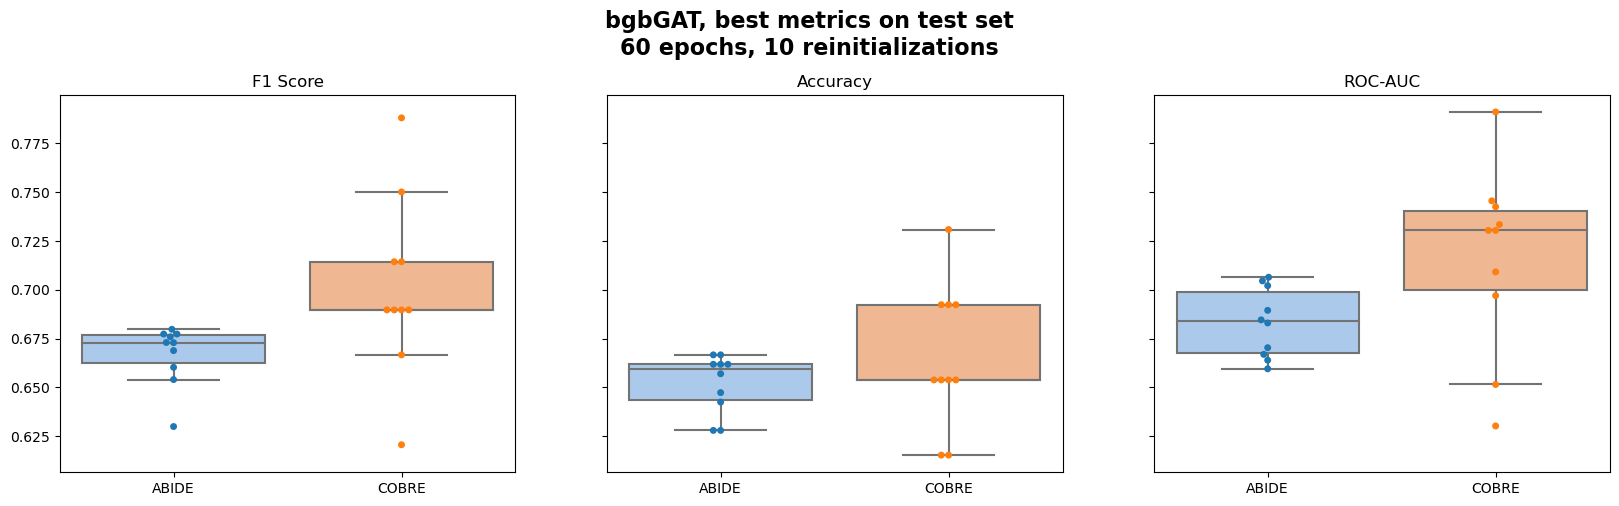

In [303]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,5), dpi=100, sharey=True)
for i, metric_name in enumerate(['F1 Score', 'Accuracy', 'ROC-AUC']):
    sns.swarmplot(data=df[df.metric==metric_name], x='dataset', y='value', ax=axes[i])
    sns.boxplot(data=df[df.metric==metric_name], x='dataset', y='value', showfliers=False, palette='pastel', ax=axes[i])
    axes[i].set_ylabel('')
    axes[i].set_xlabel('')
    axes[i].set_title(metric_name)
plt.suptitle('bgbGAT, best metrics on test set\n60 epochs, 10 reinitializations', fontsize=16, fontweight='bold', y=1.05)
plt.show()

In [294]:
std = df.groupby(['dataset', 'metric'], as_index=False).std().value
mean = df.groupby(['dataset', 'metric'], as_index=False).mean().value
max_ = df.groupby(['dataset', 'metric'], as_index=False).max().value

In [300]:
res = df.groupby(['dataset', 'metric'], as_index=False).mean().drop('value', axis=1)
res['mean'] = mean
res['std'] = std
res['max'] = max_

In [301]:
res

,dataset,metric,mean,std,max
0,ABIDE,Accuracy,0.652174,0.014933,0.666667
1,ABIDE,F1 Score,0.666935,0.015316,0.679739
2,ABIDE,ROC-AUC,0.683061,0.017477,0.706380
3,COBRE,Accuracy,0.665385,0.036488,0.730769
4,COBRE,F1 Score,0.701243,0.045270,0.787879
5,COBRE,ROC-AUC,0.716061,0.046903,0.790909


# MPL
Let's compare sophisticated Graph NN and simple MLP

In [420]:
def epoch_train(loader, clf, criterion, opt):

    clf.train(True)

    running_loss = 0
    correct = 0

    for i, data in enumerate(loader):
        inputs, labels = data
        inputs, labels = inputs.float(), labels.float()
        inputs, labels = inputs.to(device), labels.to(device)
        opt.zero_grad()
        outputs = clf(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        opt.step()
        running_loss += loss.item()
        correct += (outputs.argmax(-1) == labels.argmax(-1)).sum() / len(labels)
    
    last_loss = running_loss / len(loader)
    accuracy = correct / len(loader)
    return last_loss, accuracy

def epoch_test(loader, clf, criterion):

    clf.eval()

    running_loss = 0
    y_pred = []
    y_true = []

    for i, data in enumerate(loader):
        inputs, labels = data
        inputs, labels = inputs.float(), labels.float()
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = clf(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        y_pred.append(outputs.detach().cpu().numpy())
        y_true.append(labels.detach().cpu().numpy())
        
    
    last_loss = running_loss / len(loader)
    y_pred = np.concatenate(y_pred, axis=0)
    y_true = np.concatenate(y_true, axis=0)
    f1, acc, roc_auc = f1_score(y_true.argmax(-1), y_pred.argmax(-1)), accuracy_score(y_true.argmax(-1), y_pred.argmax(-1)), roc_auc_score(y_true.argmax(-1), y_pred[:, 1])
  
    return last_loss, f1, acc, roc_auc


def train(train_loader, test_loader, clf, criterion, opt, n_epochs=50, verbose=True):
    
    f1s = []
    accs = []
    roc_aucs = []
    
    for epoch in range(n_epochs):
        train_loss, train_acc = epoch_train(train_loader, clf, criterion, opt)
        test_loss, test_f1, test_acc, test_roc_auc = epoch_test(test_loader, clf, criterion)
        
        f1s.append(test_f1)
        accs.append(test_acc)
        roc_aucs.append(test_roc_auc)
        
        if verbose:
            print(f'[Epoch {epoch + 1}] train loss: {train_loss:.3f}; train acc: {train_acc:.2f}; ' + 
                  f'test loss: {test_loss:.3f}; test acc: {test_acc:.2f}')
            
    f1s = np.array(f1s)
    accs = np.array(accs)
    roc_aucs = np.array(roc_aucs)
    
    return f1s.max(), accs.max(), roc_aucs.max()

In [421]:
class MLP(nn.Module):
    def __init__(self, n=200, num_classes=2):
        super(MLP, self).__init__()
        self.n = n
        self.layers = nn.Sequential(

            nn.Flatten(),
            nn.Linear(n*n, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)

        )
        
    def forward(self, x):
        return F.softmax(self.layers(x), dim=-1)
    
clf_mlp = MLP(num_classes=2).cuda()
print('Number of weights:', np.sum([np.prod(p.shape) for p in clf_mlp.parameters()]))

X = next(iter(train_loader_abide))[0].cuda()
with torch.no_grad():
    clf_X = clf_mlp(X)
    assert len(clf_X) == len(X)

Number of weights: 41488898


In [462]:
clf_mlp

MLP(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=13456, out_features=1024, bias=True)
    (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout(p=0.1, inplace=False)
    (5): Linear(in_features=1024, out_features=512, bias=True)
    (6): ReLU()
    (7): Dropout(p=0.1, inplace=False)
    (8): Linear(in_features=512, out_features=2, bias=True)
  )
)

In [422]:
opt = torch.optim.AdamW(clf_mlp.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

In [423]:
train(train_loader_abide, test_loader_abide, clf_mlp, criterion, opt, n_epochs=5)

[Epoch 1] train loss: 0.701; train acc: 0.57; test loss: 0.695; test acc: 0.58
[Epoch 2] train loss: 0.591; train acc: 0.72; test loss: 0.672; test acc: 0.63
[Epoch 3] train loss: 0.551; train acc: 0.75; test loss: 0.705; test acc: 0.60
[Epoch 4] train loss: 0.553; train acc: 0.76; test loss: 0.661; test acc: 0.64


KeyboardInterrupt: 

## ABIDE

In [430]:
res_mlp_abide = []
for _ in range(10):
    clf_mlp = MLP(n=200, num_classes=2).cuda()
    opt = torch.optim.AdamW(clf_mlp.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()
    res = train(train_loader_abide, test_loader_abide, clf_mlp, criterion, opt, n_epochs=60, verbose=False)
    res_mlp_abide.append(res)

In [431]:
res_mlp_abide

[(0.7007299270072993, 0.6618357487922706, 0.6986736409490005),
 (0.7164179104477613, 0.6714975845410628, 0.7176349710442742),
 (0.7072243346007604, 0.6570048309178744, 0.6898001120866805),
 (0.6829268292682927, 0.6521739130434783, 0.7012889968242106),
 (0.7226890756302522, 0.7053140096618358, 0.7216981132075472),
 (0.7224334600760456, 0.6763285024154589, 0.7124976648608257),
 (0.7091633466135459, 0.6618357487922706, 0.707874089295722),
 (0.714859437751004, 0.6714975845410628, 0.6955445544554455),
 (0.7067669172932332, 0.6473429951690821, 0.6789650663179526),
 (0.7106227106227108, 0.6859903381642513, 0.7274892583597983)]

## COBRE

In [432]:
res_mlp_cobre = []
for _ in range(10):
    clf_mlp = MLP(n=116, num_classes=2).cuda()
    opt = torch.optim.AdamW(clf_mlp.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()
    res = train(train_loader_cobre, test_loader_cobre, clf_mlp, criterion, opt, n_epochs=60, verbose=False)
    res_mlp_cobre.append(res)

In [433]:
res_mlp_cobre

[(0.7857142857142856, 0.7692307692307693, 0.7454545454545456),
 (0.8148148148148148, 0.8076923076923077, 0.793939393939394),
 (0.7857142857142856, 0.7692307692307693, 0.8242424242424243),
 (0.8148148148148148, 0.8076923076923077, 0.8393939393939395),
 (0.8000000000000002, 0.7692307692307693, 0.8242424242424242),
 (0.7857142857142856, 0.7692307692307693, 0.8),
 (0.8148148148148148, 0.8076923076923077, 0.7818181818181819),
 (0.7586206896551724, 0.7307692307692307, 0.7515151515151516),
 (0.8000000000000002, 0.7692307692307693, 0.8545454545454545),
 (0.7857142857142856, 0.7692307692307693, 0.7606060606060606)]

# Compare results of MLP on different datasets

In [434]:
res_mlp_cobre = np.array(res_mlp_cobre)
res_mlp_abide = np.array(res_mlp_abide)

In [435]:
df2 = {'dataset':[], 'metric':[], 'value':[]}

for i, metric_name in enumerate(['F1 Score', 'Accuracy', 'ROC-AUC']):
    df2['dataset'] = df2['dataset']+['ABIDE']*10+['COBRE']*10
    df2['metric'] = df2['metric']+[metric_name]*20
    df2['value'] = df2['value']+list(res_mlp_abide[:, i])+list(res_mlp_cobre[:, i])
    
df2 = pd.DataFrame(df2)

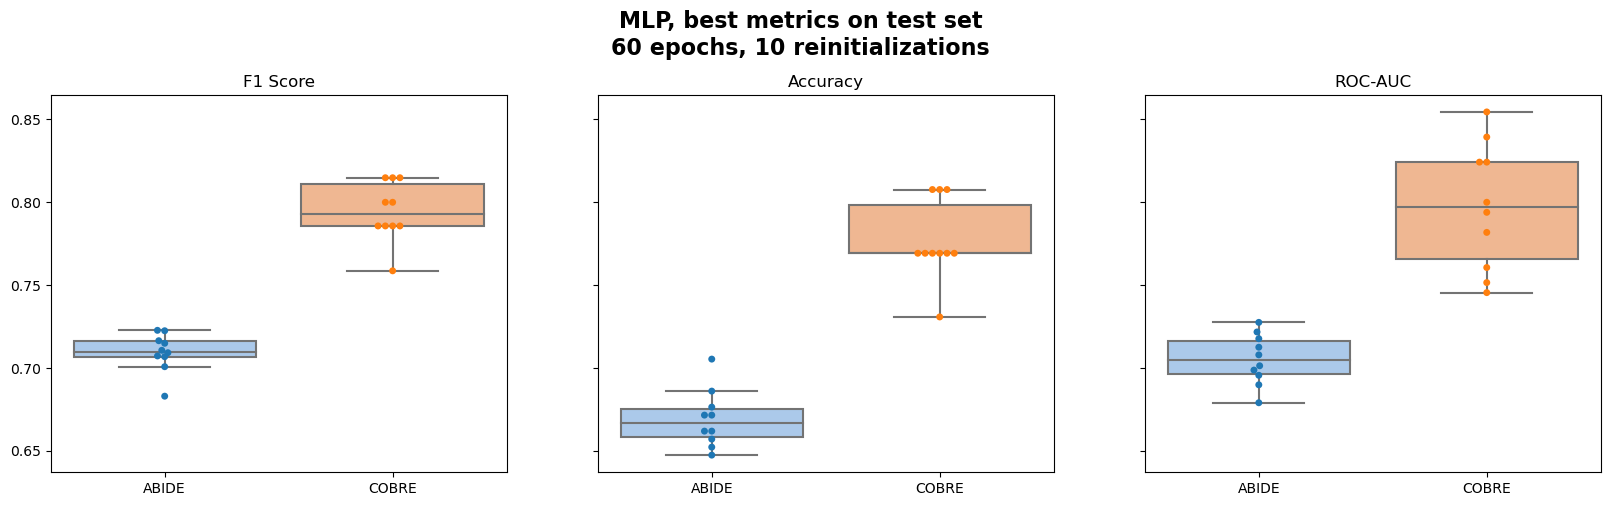

In [447]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,5), dpi=100, sharey=True)
for i, metric_name in enumerate(['F1 Score', 'Accuracy', 'ROC-AUC']):
    sns.swarmplot(data=df2[df2.metric==metric_name], x='dataset', y='value', ax=axes[i])
    sns.boxplot(data=df2[df2.metric==metric_name], x='dataset', y='value', showfliers=False, palette='pastel', ax=axes[i])
    axes[i].set_ylabel('')
    axes[i].set_xlabel('')
    axes[i].set_title(metric_name)
plt.suptitle('MLP, best metrics on test set\n60 epochs, 10 reinitializations', fontsize=16, fontweight='bold', y=1.05)
plt.show()

In [437]:
std = df2.groupby(['dataset', 'metric'], as_index=False).std().value
mean = df2.groupby(['dataset', 'metric'], as_index=False).mean().value
max_ = df2.groupby(['dataset', 'metric'], as_index=False).max().value

In [438]:
res = df2.groupby(['dataset', 'metric'], as_index=False).mean().drop('value', axis=1)
res['mean'] = mean
res['std'] = std
res['max'] = max_

In [439]:
res

,dataset,metric,mean,std,max
0,ABIDE,Accuracy,0.669082,0.017231,0.705314
1,ABIDE,F1 Score,0.709383,0.011618,0.722689
2,ABIDE,ROC-AUC,0.705147,0.015131,0.727489
3,COBRE,Accuracy,0.776923,0.024325,0.807692
4,COBRE,F1 Score,0.794592,0.017934,0.814815
5,COBRE,ROC-AUC,0.797576,0.037843,0.854545


# Aggregation of metrics from bgbGAT and MLP

In [464]:
df['network'] = ['Graph NN (bgbGAT)']*60
df2['network'] = ['MLP']*60

In [465]:
all_df = pd.concat([df, df2], axis=0)

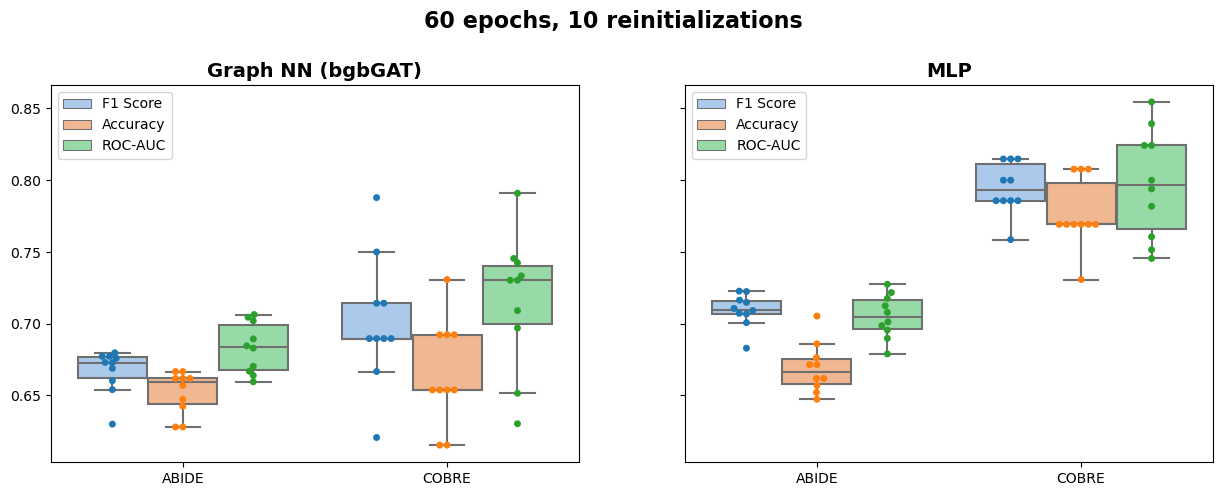

In [466]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5), dpi=100, sharey=True)
for i, net in enumerate(['Graph NN (bgbGAT)', 'MLP']):
    sns.swarmplot(data=all_df[all_df.network==net], x='dataset', y='value', hue='metric', ax=axes[i], dodge=True)
    sns.boxplot(data=all_df[all_df.network==net], x='dataset', y='value', hue='metric', showfliers=False, palette='pastel', ax=axes[i])
    axes[i].set_ylabel('')
    axes[i].set_xlabel('')
    axes[i].set_title(net, fontsize=14, fontweight='bold')
    handles, labels = axes[i].get_legend_handles_labels()
    axes[i].legend(handles[:3], labels[:3], loc=2)
plt.suptitle('60 epochs, 10 reinitializations', fontsize=16, fontweight='bold', y=1.03)
plt.show()

Unfortunately, even the simple MLP is better than Graph NN on both datasets. We suppose reasons for that are small datasets (lack of data) and specific nature of medical data. The problem is that in case of biologic/medical research it is ofter impossible to get "Big Data" so application of Graph NN seems to be overkill.